# Development Notebook for IFAT Simulator

In [1]:
from brian2 import *
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def visualize_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')

In [3]:
MODE = 'adaptive'
PARASITICS = True

In [4]:
# Define various equations

if MODE == 'adaptive':
    neuron_eq = '''
        dVm/dt = ((glm + gpar) / Cm) * (Vm_r - Vm)  : volt
        dVt/dt = ((glt + gpar) / Ct) * (Vt_r - Vt)  : volt
        
        # dVm/dt = (glm / Cm) * (Vm_r - Vm) : volt
        # dVt/dt = (glt / Ct) * (Vt_r - Vt) : volt

        glm = flm * Cl                              : siemens
        glt = flt * Cl                              : siemens
        gpar = par_ctrl / par_leak_time * Cm : siemens
    '''
    reset_eq = '''
        Vm = Vm_r
        Vt = Vt * (Vt > Vm) + Vt_r * (Vt <= Vm)
    '''
    presyn_eq = '''
        Vm_old = Vm
        Vm = Vm_old + Vsyn
        Vt += (Cst/Ct) * (Vm_old - Vm_r)
    '''
else:
    neuron_eq = '''
        dVm/dt = (glm / Cm) * (Vm_r - Vm) : volt

        glm = flm * Cl                    : siemens
    '''
    reset_eq = '''
        Vm = Vm_r
    '''
    presyn_eq = '''
        Vm_old = Vm
        Vm = Vm_old + Vsyn
    '''

# Synapse equation is the same for both modes!
syn_eq = '''
    Vsyn = (W/Cm)*(Em - Vm) : volt
    Em                      : volt
    W                       : farad
'''

In [5]:
# IFAT specific definitions
Vdd = 5 * volt
Cm = Ct = 0.44 * pF
Cl = 0.02 * pF

W_vals  = np.array([5, 10, 20, 40, 80]) * 0.001 * pF
Em_vals = np.array([0, 1/3, 2/3, 1]) * Vdd

par_ctrl = True
par_ctrl = float(PARASITICS)
par_leak_time = 12.5 * ms

In [6]:
# Model parameters
Vm_r = 1.25 * volt
flm  = 0 * kHz
Csm  = W_vals[0]

Vt_r = 3 * volt
flt  = 0 * MHz
Cst  = 0 * pF

N = 4

In [7]:
start_scope()
defaultclock.dt = 0.2 * us

In [8]:
# Start stuff up, brochacho
test = NeuronGroup(N, neuron_eq, threshold='Vm > Vt', reset=reset_eq, method='exact')
test.Vm = Vm_r
test.Vt = Vt_r

In [9]:
bg_rate = 6*kHz
bg_spk_times = np.arange(0,0.1,Hz/bg_rate) * second
bg_spk_inds  = np.zeros_like(bg_spk_times)
#bg_spks = PoissonGroup(1,rates=bg_rate)
bg_spks = SpikeGeneratorGroup(1,bg_spk_inds,bg_spk_times)

bg_syn = Synapses(bg_spks, test, syn_eq, on_pre=presyn_eq)
bg_syn.connect()
bg_syn.delay = "j * 0.2 * us"
bg_syn.Em = Em_vals[2]
bg_syn.W  = W_vals[3] + W_vals[2] + W_vals[0]

inp_rate = 500 * Hz
inp_spk_times = np.arange(0,0.1,Hz/inp_rate) * second
inp_spk_inds  = np.zeros_like(inp_spk_times)
inp_spks = SpikeGeneratorGroup(1, inp_spk_inds, inp_spk_times)

inp_syn = Synapses(inp_spks, test, syn_eq, on_pre=presyn_eq)
inp_syn.connect()
inp_syn.Em = Em_vals[2]
inp_syn.W  = sum(W_vals)

exc_syn = Synapses(test, test, syn_eq, on_pre=presyn_eq)
exc_syn.connect('j==((i+1)%(4))')
#exc_syn.connect('j==i')
exc_syn.Em = Em_vals[3]
exc_syn.W  = sum(W_vals[0:2])

inh_syn = Synapses(test, test, syn_eq, on_pre=presyn_eq)
inh_syn.connect('j==((i+2)%4)')
inh_syn.connect('j==((i+3)%4)')
inh_syn.Em = Em_vals[0]
inh_syn.W  = sum(W_vals)*2

In [10]:
#visualize_connectivity(inh_syn)

In [11]:
#visualize_connectivity(exc_syn)

In [12]:
sp_mon = SpikeMonitor(test)
vm_mon = StateMonitor(test, 'Vm', record=True, dt=0.1*ms)
vt_mon = StateMonitor(test, 'Vt', record=True, dt=0.1*ms)
ratemon = PopulationRateMonitor(test)

In [13]:
run(100*ms,report='text')

WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 5 lines of abstract code, first line is: "Vm_old := Vm (constant)"
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 5 lines of abstract code, first line is: "Vm_old := Vm (constant)"
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 5 lines of abstract code, first line is: "Vm_old := Vm (constant)"
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block tha

Starting simulation at t=0. s for a duration of 100. ms
0.0106096 (10%) simulated in 10s, estimated 1m 24s remaining.
0.0238418 (23%) simulated in 20s, estimated 1m 4s remaining.
0.036336799999999995 (36%) simulated in 30s, estimated 53s remaining.
0.049094399999999996 (49%) simulated in 40s, estimated 41s remaining.
0.061182600000000004 (61%) simulated in 50s, estimated 32s remaining.
0.0738902 (73%) simulated in 1m 0s, estimated 21s remaining.
0.0881536 (88%) simulated in 1m 10s, estimated 9s remaining.
0.1 (100%) simulated in 1m 18s


(0, 100)

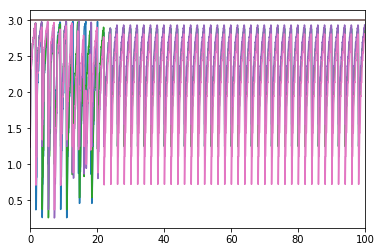

In [14]:
for i in range(N):
    plot(vm_mon.t/ms, vm_mon.Vm[i]/volt,vt_mon.t/ms, vt_mon.Vt[i]/volt)
xlim([0,100])

(0, 4)

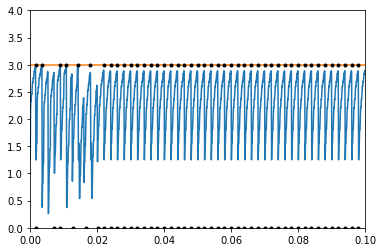

In [15]:
plot(vm_mon.t, vm_mon.Vm[1]/volt,vt_mon.t, vt_mon.Vt[0]/volt); xlim([0,0.1]);
plot(sp_mon.t, sp_mon.i*3,'.k')
ylim([0,4])

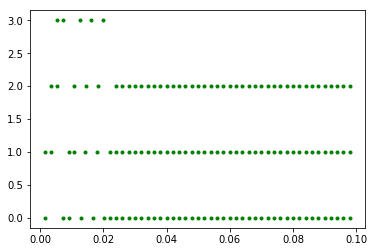

In [16]:
plot(sp_mon.t, sp_mon.i, '.g'); #xlim([0.062,0.082]);

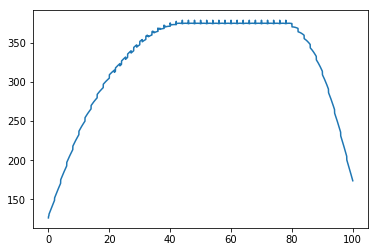

In [17]:
plot(ratemon.t/ms, ratemon.smooth_rate(width=10*ms)/Hz)

In [18]:
len(sp_mon.i[sp_mon.i==0])

45